In [1]:
%run Imports.ipynb

/Users/yashasvi/opt/anaconda3/envs/itpcowdune/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
conf = pyspark.SparkConf()
spark = SparkSession.builder.appName("Model").getOrCreate()

23/04/10 22:18:27 WARN Utils: Your hostname, Yashasvis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.232 instead (on interface en0)
23/04/10 22:18:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/10 22:18:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df2 = spark.read.parquet("/Users/yashasvi/Documents/ModelScores/")

# Type convertion to help multiply with weights

In [6]:
df2 = df2.withColumn("number_txns_double", col("number_txns").cast(DoubleType()))
df2 = df2.withColumn("num_nftcontract_double", col("num_nftcontract").cast(DoubleType()))
df2 = df2.withColumn("num_currency_double", col("num_currency").cast(DoubleType()))
# df2.dtypes

In [7]:
#Assembling Data
assemble=VectorAssembler(inputCols=[
 'avg_spent',
 'number_txns_double',
 'num_nftcontract_double',
 'num_currency_double',
 'avg_duration'], outputCol='features')
assembled_data=assemble.transform(df2)

#Standardisation
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(assembled_data)
scalar_data = scaler_model.transform(assembled_data)

In [8]:
# scores in order of features: avg_spent','number_txns','num_nftcontract','num_currency','avg_duration' add weights
scalar_data = scalar_data.withColumn("weight_param", array(lit(0.2), lit(0.25), lit(0.25), lit(0.1), lit(0.2)))

In [ ]:
scalar_data.schema.fields

In [9]:
scalar_data = scalar_data.withColumn("sfv", (vector_to_array('scaled_features', "float32")))

In [10]:
def multiply_list(list1, list2):
    list3 = [a * b for a, b in zip(list1, list2)]
    return list3

In [11]:
def sum_list(list1):
    res = 0.0
    for num in list1:
        res = res + num
    return res

In [12]:
multiply_lists_udf = udf(multiply_list, ArrayType(DoubleType()))
scalar_data = scalar_data.withColumn("result", multiply_lists_udf("sfv", "weight_param"))

In [13]:
sum_lists_udf = udf(sum_list, DoubleType())
scalar_data = scalar_data.withColumn("weight", sum_lists_udf("result"))

In [18]:
correct_data = scalar_data.filter(col("weight") >= 0.0)

# Weighted Kmeans

In [22]:
kmeans = KMeans(featuresCol='features', k=3, weightCol = 'weight',maxIter=20, initMode='k-means||')
model = kmeans.fit(correct_data)
output = model.transform(correct_data)

In [23]:
output.select('prediction').distinct().collect()

[Row(prediction=1), Row(prediction=2), Row(prediction=0)]

In [25]:
output.write.parquet("/Users/yashasvi/Documents/ModelResults/")

23/04/10 22:29:33 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/04/10 22:29:33 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/04/10 22:29:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


In [35]:
colors = ['red', 'green', 'blue']
output_p = output.toPandas()

In [41]:
def plot_correlation(output_p, color, feature1, feature2, x, y):
    for i in range(3):
        cluster_i = output_p[output_p['prediction'] == i]
        plt.scatter(cluster_i[feature1], cluster_i[feature2], color=colors[i], label=f'Cluster {i}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('Clustering of Buyers')
    plt.legend()
    plt.show()

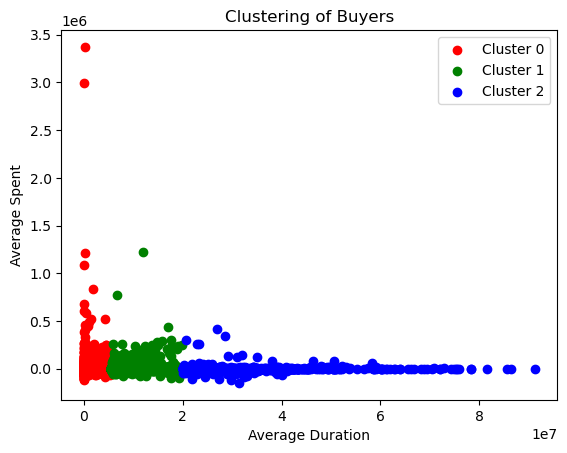

In [44]:
plot_correlation(output_p, colors, 'avg_duration','avg_spent','Average Duration','Average Spent')

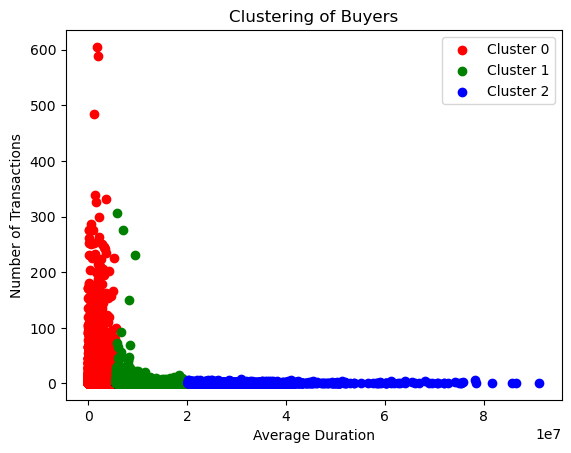

In [45]:
plot_correlation(output_p, colors, 'avg_duration','number_txns_double','Average Duration','Number of Transactions')

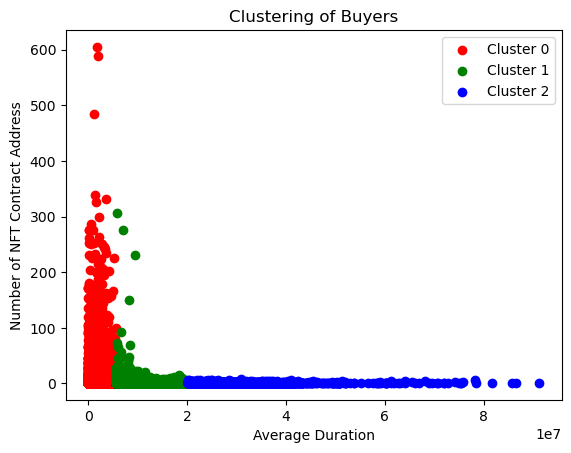

In [46]:
plot_correlation(output_p, colors, 'avg_duration','num_nftcontract_double','Average Duration','Number of NFT Contract Address')

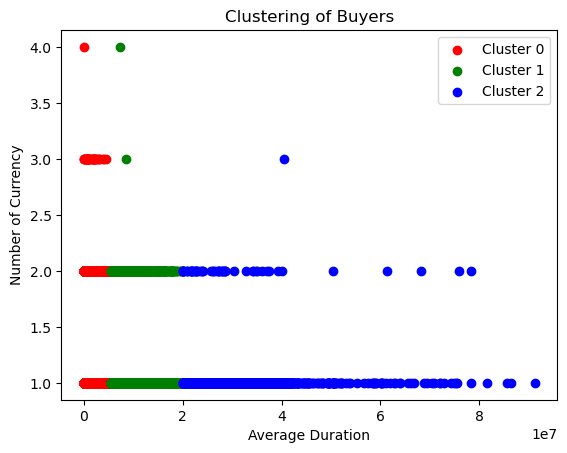

In [47]:
plot_correlation(output_p, colors, 'avg_duration','num_currency_double','Average Duration','Number of Currency')